# Run two layer model with SSP forcing

as faithful to chapters 7 and 4 as possible

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
import pickle
from multiprocessing import Pool

from ar6.utils.h5 import *
from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from fair.constants.general import EARTH_RADIUS
from ar6.forcing.aerosol import aerocom_n, ghan

import openscm_units.unit_registry as ur
from scmdata import ScmRun, run_append

from openscm_twolayermodel import TwoLayerModel
from tqdm.notebook import tqdm

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
SAMPLES = 2000
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)
F2XCO2_MEAN = 4.00
F2XCO2_NINETY = 0.48

forcing = {}
scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-gidden','ssp370-lowNTCF-aerchemmip','ssp434','ssp460','ssp534-over','ssp585']
for scenario in scenarios:
    forcing[scenario] = {}

In [4]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total['NMVOC']
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update
#new_ceds

emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
new_emissions = {}
for scenario in tqdm(scenarios):
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    oc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|OC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    so2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|Sulfur'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nh3 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NH3'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nmvoc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    bc[:265] = emissions_ceds_update.loc[1750:2014,'BC'].values
    oc[:265] = emissions_ceds_update.loc[1750:2014,'OC'].values
    so2[:265] = emissions_ceds_update.loc[1750:2014,'SO2'].values
    nh3[:265] = emissions_ceds_update.loc[1750:2014,'NH3'].values
    nox[:265] = emissions_ceds_update.loc[1750:2014,'NOx'].values
    nmvoc[:265] = emissions_ceds_update.loc[1750:2014,'VOC'].values
    co[:265] = emissions_ceds_update.loc[1750:2014,'CO'].values
    bc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'BC'].values + np.linspace(0,0.8,5) * bc[265:270]
    oc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'OC'].values + np.linspace(0,0.8,5) * oc[265:270]
    so2[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'SO2'].values + np.linspace(0,0.8,5) * so2[265:270]
    nh3[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NH3'].values + np.linspace(0,0.8,5) * nh3[265:270]
    nox[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NOx'].values + np.linspace(0,0.8,5) * nox[265:270]
    nmvoc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'VOC'].values + np.linspace(0,0.8,5) * nmvoc[265:270]
    co[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO'].values + np.linspace(0,0.8,5) * co[265:270]
    
    new_emissions[scenario] = pd.DataFrame(
    {
        'BC': bc,
        'OC': oc,
        'SO2': so2,
        'NH3': nh3,
        'NOx': nox,
        'VOC': nmvoc,
        'CO': co
    })

## Thermal parameters

I pre-calculated fits of the Geoffroy model to 44 CMIP6 models - one day I should get this data up here, but the whole process chain is a little fiddly. From this I calculate d1 and d2 - the short and long timescales of ocean temperature response in the impulse response model.

Zeb has a nice implementation of converting Geoffroy parameters to impulse response ones. I use this here. Although d1 and d2 are likely to be correlated with ECS and TCR, I'm not sure if there's a nice way to match this up to the assessment; if we use CMIP6 to inform ECS and TCR then we will get a distribution that has too many high values. Likewise we take F2x from the chapter assessment and not the models. Interesting that d1 and d2 are uncorrelated.

0.722492176996794
[2.06109769 2.33849959 2.98521046 3.99830126 5.12703314]
[1.2355143  1.44407451 1.7937823  2.21038029 2.54154444]


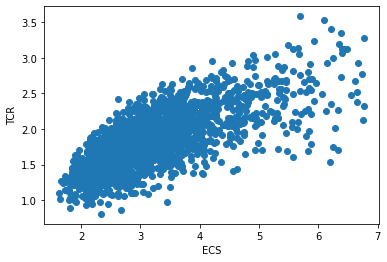

In [5]:
# draw distributions of ECS and TCR: 5-95% range 1.0 to 2.2 for TCR normal, 2-5 for ECS lognormal
seed    = SEEDS[9]

feedback = 4/3 * st.truncnorm.rvs(-2.0, np.inf, loc=1, scale=0.28, size=SAMPLES, random_state=SEEDS[18])
f2x = 4.00
ecs = f2x/feedback
rwf = st.norm.rvs(size=SAMPLES, loc=np.maximum(0.8*np.exp(-0.075*ecs**1.2), 0.2), scale=0.11*np.exp(-0.09*ecs**0.9), random_state=11)
tcr = ecs*rwf
tcrecs = np.stack((tcr,ecs)).T

pl.scatter(ecs, tcr)
pl.xlabel('ECS')
pl.ylabel('TCR')
print(np.corrcoef((ecs,tcr))[0,1])
print(np.percentile(ecs, (5,16,50,84,95)))
print(np.percentile(tcr, (5,17,50,83,95)))

(array([ 78., 589., 731., 376., 144.,  57.,  16.,   6.,   0.,   3.]),
 array([0.12386013, 0.43620308, 0.74854602, 1.06088897, 1.37323192,
        1.68557486, 1.99791781, 2.31026075, 2.6226037 , 2.93494665,
        3.24728959]),
 <BarContainer object of 10 artists>)

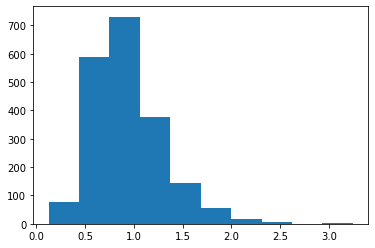

In [6]:
kappa = f2x/tcr - f2x/ecs
pl.hist(kappa)

In [7]:
f2x = st.norm.rvs(loc=F2XCO2_MEAN, scale=F2XCO2_NINETY/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[72])

with open("../data_output/cmip6_twolayer_tuning_params.json", "r") as read_file:
    cmip6_models = json.load(read_file)
params = pd.DataFrame({
    param:cmip6_models[param]['model_data'] for param in cmip6_models
})
params.drop(columns=['T4xCO2'], inplace=True)
NMODELS = len(cmip6_models)

lambda0 = feedback
efficacy = st.norm.rvs(loc=params.efficacy.mean(), scale=params.efficacy.std(), size=SAMPLES, random_state=SEEDS[65])
eta = kappa/efficacy
dl = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.dl.mean(), scale=params.dl.std(), size=SAMPLES, random_state=SEEDS[66])
du = st.truncnorm.rvs(-NINETY_TO_ONESIGMA, NINETY_TO_ONESIGMA, loc=params.du.mean(), scale=params.du.std(), size=SAMPLES, random_state=SEEDS[67])

In [8]:
cmip6_models['efficacy']['mean']

1.2951960521067662

[2.06109769 2.33849959 2.98521046 3.99830126 5.12703314]


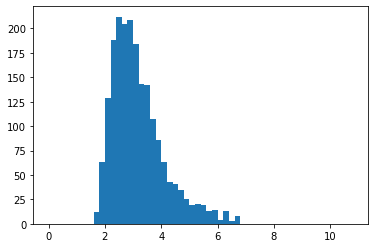

In [9]:
pl.hist(ecs, bins=np.arange(0,11,0.2))
print(np.percentile(ecs, (5,16,50,84,95)))

[1.2355143  1.43284527 1.7937823  2.23126745 2.54154444]


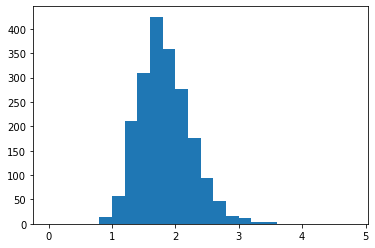

In [10]:
# TCR is alternatively given from two layer model
pl.hist(tcr, bins=np.arange(0,5,0.2))
print(np.percentile(tcr, (5,16,50,84,95)))

## Forcing uncertainties - ensure consistency with 040

In [11]:
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - half-normal
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar (amplitude)
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(SAMPLES,11), loc=np.ones((SAMPLES,11)), scale=np.ones((SAMPLES, 11)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,7]<1,7] = 0.06/0.1*(scale[scale[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale[scale[:,6]<1,6] = 0.0384/0.0406*(scale[scale[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=SAMPLES, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=138294)
#trend_solar[trend_solar>-0.01] = 11/4 * (trend_solar[trend_solar>-0.01]+0.01)-0.01

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)

### Aerosol emissions

For ERFaci, following Smith, Harris et al. 2020: Energy Budget Constraints on the Time History of Aerosol Forcing and Climate Sensitivity

For ERFari, start with Smith, Harris et al. and then add in the nitrate forcing from Myhre et al 2013

For ERFari, take coefficients from Myhre et al., 2013: Radiative forcing of the direct aerosol effect from AeroCom Phase II
simulations. The forcing calculated is 1850-2000 (or 2006; assume the same) using CMIP5 emissions.

In [13]:
df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.65/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=31318990)

ERFari = {}
ERFaci = {}

bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[97])
nit_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nox = 0.4*nit_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NOx'])-emissions_ceds_update.loc[1750,'NOx'])
beta_nh3 = 0.6*nit_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

for scenario in tqdm(scenarios):
    ERFari[scenario] = np.zeros((751,SAMPLES))
    ERFaci[scenario] = np.zeros((751,SAMPLES))
    
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    nox = new_emissions[scenario]['NOx'].values.squeeze()
    
    for i in tqdm(range(SAMPLES), leave=False):
        ERFari[scenario][:, i] = (
            (so2-so2[0]) * beta_so2[i] +
            (bc-bc[0]) * beta_bc[i] +
            (oc-oc[0]) * beta_oc[i] +
            (nh3-nh3[0]) * beta_nh3[i] +
            (nox-nox[0]) * beta_nox[i]
        )
    
    for i in tqdm(range(SAMPLES), leave=False):

        ts2010 = np.mean(
            ghan(
                [
                    so2[255:265],
                        bc[255:265]+
                        oc[255:265],
                ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
            )
        )
        ts1750 = ghan(
            [
                so2[0],
                    bc[0]+
                    oc[0],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
        ERFaci[scenario][:,i] = (
            ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
        - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

### Testing and scaling aerosol emissions

The ERFari has some funky possible time evolutions - these could be filtered out based on some criterion

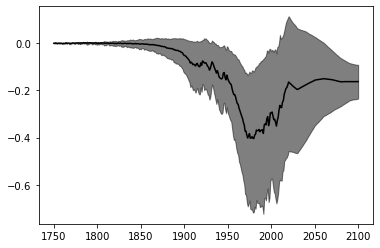

In [14]:
pl.fill_between(np.arange(1750, 2101), np.percentile(ERFari['ssp245'], 5, axis=1)[:351], np.percentile(ERFari['ssp245'], 95, axis=1)[:351], color='k', alpha=0.5)
pl.plot(np.arange(1750,2101), np.percentile(ERFari['ssp245'], 50, axis=1)[:351], color='k')

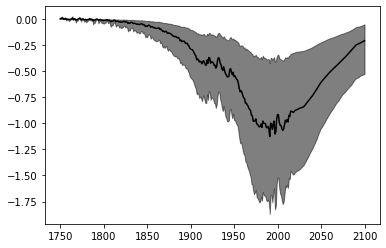

In [15]:
pl.fill_between(np.arange(1750, 2101), np.percentile(ERFaci['ssp245'], 5, axis=1)[:351], np.percentile(ERFaci['ssp245'], 95, axis=1)[:351], color='k', alpha=0.5)
pl.plot(np.arange(1750,2101), np.percentile(ERFaci['ssp245'], 50, axis=1)[:351], color='k')

In [16]:
ERFaer = {}
for scenario in scenarios:
    ERFaer[scenario] = ERFari[scenario]+ERFaci[scenario]

## Non-aerosol forcings

In [18]:
for scenario in scenarios:
    outname = scenario
    if scenario=='ssp370-lowNTCF':
        outname='ssp370-lowNTCF-gidden'
    df = pd.read_csv('../data_output/SSPs/ERF_%s_1750-2500.csv' % outname)
    forcing_ensemble = {}
    forcing_ensemble['co2'] = df['co2'].values[:,None] * scale_df['co2'].values[None,:]
    forcing_ensemble['ch4'] = df['ch4'].values[:,None] * scale_df['ch4'].values[None,:]
    forcing_ensemble['n2o'] = df['n2o'].values[:,None] * scale_df['n2o'].values[None,:]
    forcing_ensemble['other_wmghg'] = df['other_wmghg'].values[:,None] * scale_df['other_wmghg'].values[None,:]
    forcing_ensemble['o3'] = df['o3'].values[:,None] * scale_df['o3'].values[None,:]
    forcing_ensemble['h2o_stratospheric'] = df['h2o_stratospheric'].values[:,None] * scale_df['h2o_stratospheric'].values[None,:]
    forcing_ensemble['contrails'] = df['contrails'].values[:,None] * scale_df['contrails'].values[None,:]
    forcing_ensemble['aerosol-radiation_interactions'] = ERFari[scenario]
    forcing_ensemble['aerosol-cloud_interactions'] = ERFaci[scenario]
    forcing_ensemble['bc_on_snow'] = df['bc_on_snow'].values[:,None] * scale_df['bc_on_snow'].values[None,:]
    forcing_ensemble['land_use'] = df['land_use'].values[:,None] * scale_df['land_use'].values[None,:]
    forcing_ensemble['volcanic'] = df['volcanic'].values[:,None] * scale_df['volcanic'].values[None,:]
    forcing_ensemble['solar'] = df['solar'].values[:,None] * scale_df['solar'].values[None,:]
    forcing_ensemble['total'] = (
        forcing_ensemble['co2'] +
        forcing_ensemble['ch4'] +
        forcing_ensemble['n2o'] +
        forcing_ensemble['other_wmghg'] +
        forcing_ensemble['o3'] +
        forcing_ensemble['h2o_stratospheric'] +
        forcing_ensemble['contrails'] +
        forcing_ensemble['aerosol-radiation_interactions'] +
        forcing_ensemble['aerosol-cloud_interactions'] +
        forcing_ensemble['bc_on_snow'] +
        forcing_ensemble['land_use'] +
        forcing_ensemble['volcanic'] +
        forcing_ensemble['solar']
    )
    forcing[scenario] = forcing_ensemble['total']

In [19]:
forcing['ssp245'].shape

(751, 2000)

# Run climate model

try take advantage of scmdata's multi-run

In [20]:
arglist = []

dl = np.array(dl)
du = np.array(du)
eta = np.array(eta)
lambda0 = np.array(lambda0)
efficacy = np.array(efficacy)

for i in range(SAMPLES):
    arglist.append(
        {
            'dl': dl[i],
            'du': du[i],
            'eta': eta[i],
            'lambda0': lambda0[i],
            'efficacy': efficacy[i],
            'in_forcing' : forcing_ensemble['total'][:,i],
            'run_id': i
        }
    )

In [23]:
runner = TwoLayerModel()

results = {}

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = ScmRun(
        data=in_forcing,#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2501),
        columns={
            "unit": "W/m^2",
            "model": "openscm-twolayermodel-0.2.0",
            "scenario": "historical-AR6",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": args['run_id']
        }
    )
    runner.dl = args['dl']*ur(cmip6_models['dl']['units'])
    runner.du = args['du']*ur(cmip6_models['du']['units'])
    runner.eta = args['eta']*ur(cmip6_models['eta']['units'])
    runner.lambda0 = args['lambda0'] * ur(cmip6_models['lambda0']['units'])
    runner.efficacy = args['efficacy'] * ur(cmip6_models['efficacy']['units'])
    return (runner.run_scenarios(driver, progress=False))

if __name__ == '__main__':
    for scenario in tqdm(scenarios, desc="Scenarios"):
        output = []
        with Pool(16) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES, leave=False))
        output = run_append(result)
        
        results[scenario] = {}
        MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
        results[scenario]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
        results[scenario]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T
        results[scenario]['deep_ocean_temperature'] = output.filter(variable='Surface Temperature|Lower').timeseries().values.T
        results[scenario]['net_energy_imbalance'] = output.filter(variable='Heat Uptake').timeseries().values.T
        results[scenario]['ocean_heat_content'] = (
            np.cumsum(results[scenario]['net_energy_imbalance'], axis=0) * 4 * np.pi * EARTH_RADIUS**2 * MODEL_TIMESTEP
        )
        results[scenario]['ECS'] = ecs#.values
        results[scenario]['TCR'] = tcr#.values
        results[scenario]['lambda0'] = lambda0
        results[scenario]['eta'] = eta
        results[scenario]['efficacy'] = efficacy
        results[scenario]['dl'] = dl
        results[scenario]['du'] = du

    save_dict_to_hdf5(results, '../data_input_large/twolayer_SSPs.h5')

In [ ]:
# runner = TwoLayerModel()

# dl = np.array(geoff_sample_df['dl']) * ur(cmip6_models['dl']['units'])
# du = np.array(geoff_sample_df['du'])  * ur(cmip6_models['du']['units'])
# eta = np.array(geoff_sample_df['eta']) * ur(cmip6_models['eta']['units'])
# lambda0 = np.array(geoff_sample_df['lambda0']) *  ur(cmip6_models['lambda0']['units'])
# efficacy = np.array(geoff_sample_df['efficacy']) * ur(cmip6_models['efficacy']['units'])

# results = {}

# for scenario in tqdman.tqdm(scenarios, desc="Scenarios"):
#     output = []
#     for i in tqdman.tqdm(range(SAMPLES), desc="Parameter settings", leave=False):
#         driver = ScmRun(
#             data=forcing[scenario][:,i],#[:,None]*np.ones((270,500)),
#             index=np.arange(1750,2501),
#             columns={
#                 "unit": "W/m^2",
#                 "model": "openscm-twolayermodel-0.2.0",
#                 "scenario": scenario,
#                 "region": "World",
#                 "variable": "Effective Radiative Forcing",
#                 "run_id": i
#             }
#         )
#         runner.dl = dl[i]
#         runner.du = du[i]
#         runner.eta = eta[i]
#         runner.lambda0 = lambda0[i]
#         runner.efficacy = efficacy[i]
#     #    runner.timestep = 1 * ur("month")
#         output.append(runner.run_scenarios(driver, progress=False))
#     output = run_append(output)
    
#     results[scenario] = {}
#     MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
#     results[scenario]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
#     results[scenario]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T
#     results[scenario]['deep_ocean_temperature'] = output.filter(variable='Surface Temperature|Lower').timeseries().values.T
#     results[scenario]['net_energy_imbalance'] = output.filter(variable='Heat Uptake').timeseries().values.T
#     results[scenario]['ocean_heat_content'] = (
#         np.cumsum(results[scenario]['net_energy_imbalance'], axis=0) * 4 * np.pi * EARTH_RADIUS**2 * MODEL_TIMESTEP
#     )
#     results[scenario]['ECS'] = ecs#.values
#     results[scenario]['TCR'] = tcr#.values
#     results[scenario]['lambda0'] = lambda0.magnitude
#     results[scenario]['eta'] = eta.magnitude
#     results[scenario]['efficacy'] = efficacy.magnitude
#     results[scenario]['dl'] = dl.magnitude
#     results[scenario]['du'] = du.magnitude

# save_dict_to_hdf5(results, '../data_input_large/twolayer_SSPs.h5')